In [43]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

%matplotlib inline

In [44]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [ ]:
df = pd.read_csv('./data/train.csv')
df.head(30)

In [46]:
a = [0,1,2,3,4,5,6,7,8,9]
a[4:8]

[4, 5, 6, 7]

In [47]:
def get_fps(df):
    temp_fps = df['ImageId_ClassId'].values
    fps = []
    for x in temp_fps:
        f = x.split('_')[0]
        if f not in fps:
            fps.append(f)
    return fps

In [48]:
def make_masks(idx, df, shape):
    image_id = idx*4
    fp = df['ImageId_ClassId'][image_id]
    d = df[image_id:image_id+4]
    masks = np.zeros((4,shape[0],shape[1]))
    class_ids = []
    for _,x in d.iterrows():
        if x["EncodedPixels"] is not np.nan:
            cls_id = int(x['ImageId_ClassId'].split('_')[1])
            masks[cls_id - 1] = rle2mask(x["EncodedPixels"])
            class_ids.append(cls_id)       
            
    if(len(class_ids) == 0):
        class_ids.append(0)
    
    return np.array(masks),class_ids

In [49]:
x = get_fps(df)
print(x[:5])
len(x)

['0002cc93b.jpg', '00031f466.jpg', '000418bfc.jpg', '000789191.jpg', '0007a71bf.jpg']


12568

In [50]:
x[4]

'0007a71bf.jpg'

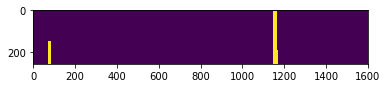

In [51]:
plt.imshow(make_masks(4,df,(256,1600))[0][2])

In [52]:
50272/4

12568.0

In [53]:
6666 + 5902 #(defects + normals)

12568

In [54]:
train_df = df[df['EncodedPixels'].notnull()]

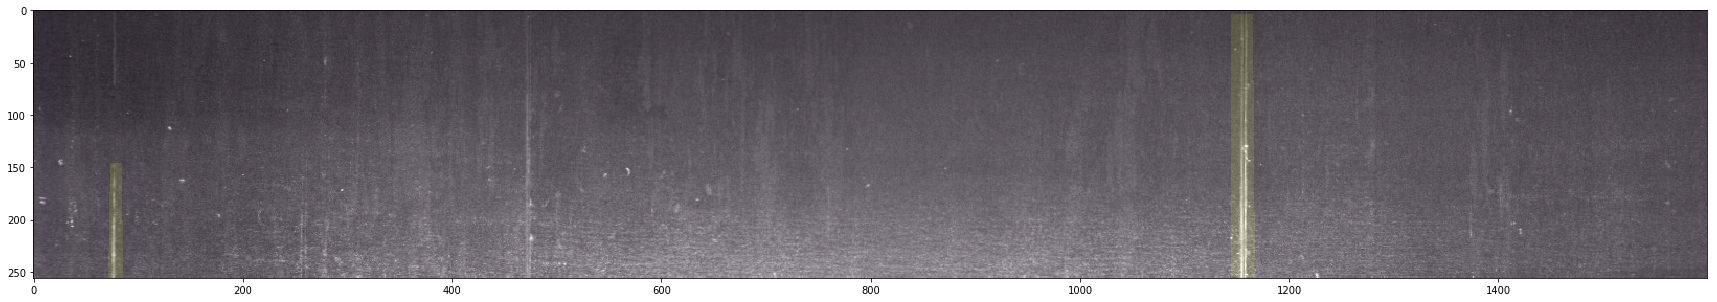

In [13]:
plt.figure(figsize = (30,30))
plt.imshow(cv2.imread('./data/train_images/0007a71bf.jpg'))
plt.imshow(rle2mask(train_df['EncodedPixels'][18]),alpha=0.1)

In [55]:
len(set())

0

(256, 1600, 3)


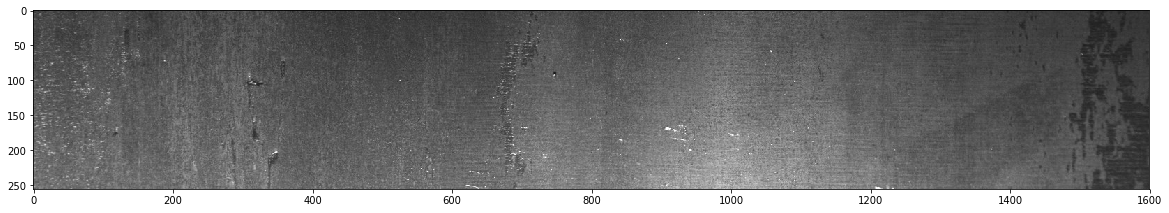

In [14]:
x = cv2.imread('./data/train_images/0002cc93b.jpg')
print(x.shape)
plt.figure(figsize = (20,20))
plt.imshow(x)

In [56]:

DATA_DIR = './data/train_images/'

In [57]:
class SeverstalSteel(Dataset):
    def __init__(self,df, mode ='train'):
        
        self.df = df
        self.fps = get_fps(self.df)
        self.class_ids = []
        
    
    def __getitem__(self, idx):
        
        
        img = cv2.imread(DATA_DIR + self.fps[idx])             ## Img  
        masks, cls_idx = make_masks(idx,self.df,img.shape)     ## Masks and Class
        self.class_ids.append(cls_idx)
        
        return img, masks
        
    
    def __len__(self):
        return(len(self.fps))
        
        

In [13]:
train = SeverstalSteel()

TypeError: __init__() missing 1 required positional argument: 'df'

In [16]:
img,mask = train[0]

NameError: name 'train' is not defined

In [17]:
train.class_ids

NameError: name 'train' is not defined

In [15]:
print(img.shape)
print(mask.shape)

NameError: name 'img' is not defined

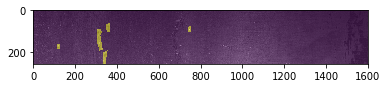

In [61]:
plt.imshow(img)
plt.imshow(mask[0],alpha=0.5)

In [58]:
def get_straify_values(df):
    t =0
    defects = []
    for i in range(0,len(df),4):
        d = df.iloc[i:i+4]
        if (d['EncodedPixels'].isna().sum()) == 4:
            defects.append(0)
        else:
            defects.append(1)
    
    return defects
            

In [59]:
defects = get_straify_values(df)

In [60]:
print(len(defects))
print(np.sum(defects))

12568
6666


In [61]:
i = [i for i in range(len(defects))]
trainidx , testidx  = train_test_split(i, test_size=0.2, stratify=defects)

In [62]:
len(testidx)

2514

In [63]:
np.sort(i)

array([    0,     1,     2, ..., 12565, 12566, 12567])

In [64]:
12567*4 

50268

In [65]:
def convert_idx(idx):
    
    '''
    Convert split idxs to DF idxs
    
    '''
    df_idx = []
    for x in idx:
        for j in range((x*4),(x*4)+4):
            df_idx.append(j)
    
    return df_idx
    

In [66]:
train_idx = np.sort(convert_idx(trainidx))
test_idx = np.sort(convert_idx(testidx))

In [67]:
train_idx[:10]

array([ 4,  5,  6,  7,  8,  9, 10, 11, 16, 17])

In [68]:
len(train_idx) + len(test_idx)

50272

In [69]:
df_train = df.iloc[train_idx].reset_index()
df_test = df.iloc[test_idx].reset_index()

In [ ]:
df_train.head(20)

In [71]:
df_train['EncodedPixels'][0]

nan

In [72]:
dataset_train = SeverstalSteel(df_train)
dataset_test = SeverstalSteel(df_test)

In [73]:
dataset_train.fps[0]

'00031f466.jpg'

In [74]:
img,mask = dataset_train[4]

In [75]:
mask.shape

(4, 256, 1600)

In [76]:
np.sum(mask)

69357.0

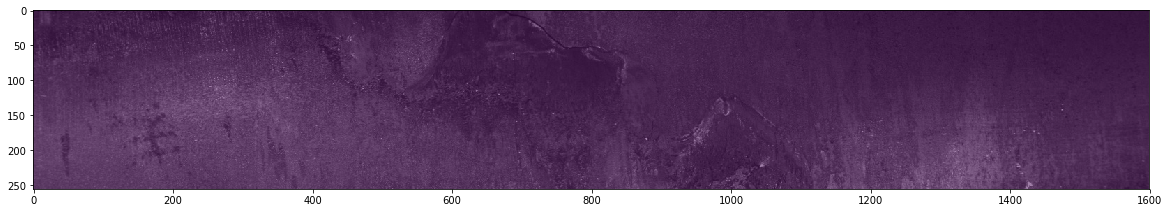

In [37]:
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.imshow(mask[0],alpha=0.5)

In [77]:
import segmentation_models_pytorch as smp

model = smp.Unet('se_resnext50_32x4d', encoder_weights='imagenet', classes=4)

In [ ]:
model

In [79]:
dataloader_train = DataLoader(
        dataset_train,
        batch_size=2,
        num_workers=0,
        pin_memory=True,
        shuffle=True,   
    )

dataloader_test = DataLoader(
        dataset_test,
        batch_size=2,
        num_workers=0,
        pin_memory=True,
        shuffle=True,   
    )

In [56]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

NameError: name 'trainloader' is not defined

In [38]:
# from multiprocessing import set_start_method
# try:
#     set_start_method('spawn')
# except RuntimeError:
#     pass

In [80]:
device = torch.device("cuda:0")
# torch.set_default_tensor_type("torch.cuda.FloatTensor")
model = model.to(device)

In [81]:
1+1

2

In [82]:
len(dataset_train)/2

5027.0

In [83]:
len(dataloader_train)

5027

In [ ]:
class Meter:
        
        

In [ ]:
class Trainer:
    

In [40]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

running_loss = 0.0

for idx, data in enumerate(dataloader_train):
    img,mask = data
    
    img = img.to(device)
    mask = mask.to(device)
    
    
    img = img.view(2,3, 256 , -1)

    img  = img.float()
    mask = mask.float()
    
    optimizer.zero_grad()
    
    outputs = model(img)
       
    loss = criterion(outputs,mask)
  
    loss.backward()
    
    optimizer.step()
    
    running_loss += loss.item()
#     print(running_loss)
    
    if idx % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, idx + 1, running_loss / 2000))
        running_loss = 0.0
    
    

0.5895659327507019
1.1632581949234009
1.7481997609138489
2.3335362672805786
2.9131988286972046
3.495250642299652
4.067690491676331
4.625671684741974
5.19789332151413
5.778904139995575
6.3314292430877686
6.897390127182007
7.444733798503876
8.028240621089935
8.621585011482239
9.164294362068176
9.727481245994568
10.270692586898804
10.81826263666153
11.408717393875122
11.936550378799438


KeyboardInterrupt: 